In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
dist  = "normal"
mu_list    = [150]
sigma_list = [75,112.5,150]
v_list     = [8]
m_list     = [1,2,3]
c_list     = [2,3,4]
c_D_list   = [0,0.25,0.5,0.75,1]
c_Q_list   = [0,0.25,0.5,0.75,1]
s_list     = [0.5,0.6,0.7]
delta_list = [0,0.2,0.4,0.6,0.8,1]

In [3]:
pairs  = list(itertools.product(mu_list, sigma_list, v_list, m_list, c_list, c_D_list, c_Q_list, s_list, delta_list))


In [4]:
def getA(v, delta, s):
    return v*(1-delta) + (1+delta)*s

def getB(v, delta, s, c):
    return s*v - delta*c*(v-s)

# Traditional System
def optimal_price_trad(v, delta, s, c):
    A = getA(v, delta, s)
    B = getB(v, delta, s, c)
    return (A+np.sqrt(A*A-4*B))/2

# Quick Response System
def optimal_price_quick(v, delta, s, c, c_Q):
    p_Q = v - delta * c_Q * (v - s)/(c + c_Q - s)
    return p_Q

# Enhanced Deisgn
def optimal_price_enhanced(v, delta, s, c, c_D, m):
    A = getA(v+m, delta, s)
    B = getB(v+m, delta, s, c+c_D)
    return (A+np.sqrt(A*A-4*B))/2

# Fast Fashion 
def optimal_price_fast(v, delta, s, c, c_D, c_Q, m):
    p_F = v+m - delta * (v + m - s) * c_Q / (c + c_D + c_Q - s)
    return p_F

In [5]:
class Instance:
    def expected_sales(self, q):
        rv = np.random.normal(self.mu, self.sigma, 50000)
        rv = np.where(rv < 0, 0, rv) - q
        e_sales = q + (np.sum(rv[np.where(rv < 0)]) / 50000)
        return e_sales
        
    def expected_lost_and_inventory(self, q):
        rv = np.random.normal(self.mu, self.sigma, 50000)
        rv = np.where(rv < 0, 0, rv) - q
        e_lost = np.sum(rv[np.where(rv > 0)]) / 50000
        e_inv = -np.sum(rv[np.where(rv < 0)]) / 50000
        return e_lost, e_inv
    
    def explain(self):
        print(f"sigma : {self.sigma}, m:{self.m}, c:{self.c}, c_D:{self.c_D}, c_Q:{self.c_Q}, s:{self.s}, delta:{self.delta}")
        print(f"p_T : {self.p_T}, p_D:{self.p_D}, p_Q:{self.p_Q}, p_F:{self.p_F}")
        print(f"q_T : {self.q_T}, q_D:{self.q_D}, q_Q:{self.q_Q}, q_F:{self.q_F}")
        print(f"phi_T : {self.phi_T}, phi_D:{self.phi_D}, phi_Q:{self.phi_Q}, phi_F:{self.phi_F}")
        
    def __init__(self, *args):
        args = args[0]
        mu, sigma, v, m, c = args[0], args[1], args[2], args[3], args[4]
        c_D, c_Q, s, delta = round(args[5]*c,5), round(args[6]*c,5), round(args[7]*c,5), args[8]
        self.mu, self.sigma = mu, sigma
        
        # Traditional
        p_T = optimal_price_trad(v, delta, s, c)  
        q_T = max(norm.ppf((p_T - c)/(p_T - s))*sigma + mu, 0)
        phi_T = (p_T - s) * self.expected_sales(q_T) - (c - s) * q_T
        
        # Quick Response
        p_Q = optimal_price_quick(v, delta, s, c, c_Q)
        if c_Q == 0:
            q_Q = 0
            phi_Q = (p_Q - c) * mu
        elif p_Q < c + c_Q:
            p_Q = optimal_price_trad(v, delta, s, c)
            q_Q = max(norm.ppf((p_Q - c)/(p_Q - s))*sigma + mu,0)
            phi_Q = (p_Q - s) * self.expected_sales(q_Q) - (c - s) * q_Q
        else:
            q_Q = max(norm.ppf((c_Q)/(c + c_Q - s))*sigma + mu,0)
            e_lost, e_inv = self.expected_lost_and_inventory(q_Q)
            phi_Q = (p_Q - c) * mu - c_Q * e_lost - (c - s) * e_inv
        
        # Enhanced Design
        p_D = optimal_price_enhanced(v, delta, s, c, c_D, m)
        q_D = max(norm.ppf((p_D - c - c_D)/(p_D - s))*sigma + mu,0)
        phi_D = max((p_D - s) * self.expected_sales(q_D) - (c + c_D - s) * q_D,0)
        
        # Fast Fahion
        p_F = optimal_price_fast(v, delta, s, c, c_D, c_Q, m)
        if c_Q == 0:
            q_F = 0
            phi_F = (p_F - c - c_D) * mu
        elif p_Q < c + c_Q + c_D:
            p_F = optimal_price_trad(v+m, delta, s, c+c_D)
            q_F = max(norm.ppf((p_F - c - c_D)/(p_F - s))*sigma + mu,0)
            phi_F = max((p_F - s) * self.expected_sales(q_F) - (c + c_D - s) * q_F,0)
        else:
            q_F = max(norm.ppf(c_Q/(c + c_Q + c_D - s))*sigma + mu,0)
            e_lost, e_inv = self.expected_lost_and_inventory(q_F)
            phi_F = max((p_F - c - c_D) * mu - c_Q * e_lost - (c + c_D - s) * e_inv,0)
        
        self.v, self.m, self.c, self.c_D, self.c_Q, self.s, self.delta,\
        self.p_T, self.q_T, self.phi_T, self.p_Q, self.q_Q, self.phi_Q, \
        self.p_D, self.q_D, self.phi_D, self.p_F, self.q_F, self.phi_F \
        = v, m, c, c_D, c_Q, s, delta, p_T, q_T, phi_T, p_Q, q_Q, phi_Q,\
        p_D, q_D, phi_D, p_F, q_F, phi_F
            
    def get_complementarity_factor(self):
        complementarity = ((self.phi_F - self.phi_D) - (self.phi_Q - self.phi_T)) / self.phi_T
        return complementarity

In [6]:
c_D_by_c_inst        = []
delta_inst           = []
complementarity_inst = []
instance_list = []

count = 0

for idx,pair in enumerate(pairs):
    if idx % 100 == 0 :
        print(idx)
    inst = Instance(pair)
#     print(inst.p_T, inst.p_D, inst.p_Q, inst.p_F)
#     print(inst.phi_T, inst.phi_D, inst.phi_Q, inst.phi_F)
    instance_list.append(inst)
    
    c_D_by_c_inst.append(pair[5])
    delta_inst.append(pair[8])
    
    complementarity_inst.append(inst.get_complementarity_factor())
#     if sim.phi_F >= sim.phi_D-0.00001 and sim.phi_F >= sim.phi_Q-0.00001 and sim.phi_F >=sim.phi_T-0.00001:
#         count+=1
print(count)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
0


In [8]:
complementarity_list = []
for inst in instance_list:
    complementarity_list.append(inst.get_complementarity_factor())

inst = instance_list[complementarity_list.index(max(complementarity_list))]
print(inst.p_T, inst.p_D, inst.p_Q, inst.p_F)
print(inst.phi_T, inst.phi_D, inst.phi_Q, inst.phi_F)
print(max(complementarity_list))


5.464101615137754 6.242640687119285 8.0 11.0
59.19476007734579 135.92068157915975 600.0 1050.0
6.305863525934629


# Example delta = 1, c_d/c = 1

In [31]:
count, count_0,count_1,count_2, count_3, count_4 = 0,0,0,0,0,0
for inst in instance_list:
    if inst.c_D == inst.c and inst.delta == 1:
        count += 1
        if inst.get_complementarity_factor() < -0.02:
            if inst.c_Q / inst.c == 0: count_0 += 1 
            if inst.c_Q / inst.c == 0.25: count_1 += 1 
            if inst.c_Q / inst.c == 0.5: count_2 += 1 
            if inst.c_Q / inst.c == 0.75: count_3 += 1 
            if inst.c_Q / inst.c == 1: count_4 += 1 

            inst.explain()
            print(inst.get_complementarity_factor(),"\n")

print(count,count_0,count_1,count_2, count_3, count_4)

sigma : 75, m:1, c:2, c_D:2, c_Q:0, s:1.0, delta:1
p_T : 3.6457513110645907, p_D:5.898979485566356, p_Q:8.0, p_F:9.0
q_T : 173.31234034990214, q_D:128.58691491762016, q_Q:0, q_F:0
phi_T : 173.1374234696622, phi_D:147.16184308314638, phi_Q:900.0, phi_F:750.0
-0.7163351349930202 

sigma : 75, m:1, c:2, c_D:2, c_Q:0, s:1.2, delta:1
p_T : 3.53238075793812, p_D:5.873328578219169, p_Q:8.0, p_F:9.0
q_T : 180.32227405337133, q_D:131.16496078153924, q_Q:0, q_F:0
phi_T : 167.64716343724754, phi_D:148.79490703488318, phi_Q:900.0, phi_F:750.0
-0.7822842982173446 

sigma : 75, m:1, c:2, c_D:2, c_Q:0, s:1.4, delta:1
p_T : 3.38997487421324, p_D:5.845222154178574, p_Q:8.0, p_F:9.0
q_T : 189.00439965284752, q_D:133.91707162745217, q_Q:0, q_F:0
phi_T : 157.2389612885112, phi_D:148.8494359689385, phi_Q:900.0, phi_F:750.0
-0.9006067804059843 

sigma : 75, m:1, c:2, c_D:2, c_Q:1.0, s:1.0, delta:1
p_T : 3.6457513110645907, p_D:5.898979485566356, p_Q:4.5, p_F:5.898979485566356
q_T : 173.31234034990214, q_D:1

In [33]:
count, count_0,count_1,count_2, count_3, count_4 = 0,0,0,0,0,0
for inst in instance_list:
    if inst.c_D == inst.c and inst.delta == 1:
        count += 1
        if inst.get_complementarity_factor() > 0.02:
            if inst.m == 1: count_1 += 1 
            if inst.m == 2: count_2 += 1
            if inst.m == 3: count_3 += 1
            

            inst.explain()
            print(inst.get_complementarity_factor(),"\n")

print(count,count_1,count_2, count_3)

sigma : 75, m:1, c:2, c_D:2, c_Q:0.5, s:1.0, delta:1
p_T : 3.6457513110645907, p_D:5.898979485566356, p_Q:5.666666666666666, p_F:7.857142857142858
q_T : 173.31234034990214, q_D:128.58691491762016, q_Q:117.69545255284069, q_F:69.9322107091394
phi_T : 174.12226121539445, phi_D:147.31502533870633, phi_Q:509.8449273743639, phi_F:521.0600239409582
0.21836571715691008 

sigma : 75, m:1, c:2, c_D:2, c_Q:0.5, s:1.2, delta:1
p_T : 3.53238075793812, p_D:5.873328578219169, p_Q:5.384615384615385, p_F:7.818181818181818
q_T : 180.32227405337133, q_D:131.16496078153924, q_Q:127.9964075909105, q_F:72.75324283309737
phi_T : 167.40470768965363, phi_D:148.87968613611736, phi_Q:470.8745355809777, phi_F:516.2240545232083
0.3815576119530758 

sigma : 75, m:1, c:2, c_D:2, c_Q:0.5, s:1.4, delta:1
p_T : 3.38997487421324, p_D:5.845222154178574, p_Q:5.0, p_F:7.774193548387097
q_T : 189.00439965284752, q_D:133.91707162745217, q_Q:141.43610292589287, q_F:75.81235294945236
phi_T : 157.23880840383188, phi_D:150.4506

# Sigma

In [50]:
sigma1, sigma2, sigma3 = [], [], []
for inst in instance_list:
    if inst.sigma == 75:
        sigma1.append(inst.get_complementarity_factor())
    if inst.sigma ==112.5:
        sigma2.append(inst.get_complementarity_factor())
    if inst.sigma == 150:
        sigma3.append(inst.get_complementarity_factor())

print(sum(sigma1) / len(sigma1))
print(sum(sigma2) / len(sigma2))
print(sum(sigma3) / len(sigma3))

0.10931249017989443
0.15420262976519764
0.19972746944896677


# M

In [51]:
m1, m2, m3 = [], [], []
for inst in instance_list:
    if inst.m == 1:
        m1.append(inst.get_complementarity_factor())
    if inst.m == 2:
        m2.append(inst.get_complementarity_factor())
    if inst.m == 3:
        m3.append(inst.get_complementarity_factor())

print(sum(m1) / len(m1))
print(sum(m2) / len(m2))
print(sum(m3) / len(m3))

0.0011551922530794374
0.15566945868592208
0.3064179384550571


# C

In [52]:
c1, c2, c3 = [], [], []
for inst in instance_list:
    if inst.c == 2:
        c1.append(inst.get_complementarity_factor())
    if inst.c == 3:
        c2.append(inst.get_complementarity_factor())
    if inst.c == 4:
        c3.append(inst.get_complementarity_factor())

print(sum(c1) / len(c1))
print(sum(c2) / len(c2))
print(sum(c3) / len(c3))

0.2968571238175379
0.13627290066453918
0.030112564911981585


# C_D

In [53]:
c_D1, c_D2, c_D3, c_D4, c_D5 = [], [], [], [], []
for inst in instance_list:
    if inst.c_D/inst.c == 0:
        c_D1.append(inst.get_complementarity_factor())
    if inst.c_D/inst.c == 0.25:
        c_D2.append(inst.get_complementarity_factor())
    if inst.c_D/inst.c == 0.5:
        c_D3.append(inst.get_complementarity_factor())
    if inst.c_D/inst.c == 0.75:
        c_D4.append(inst.get_complementarity_factor())
    if inst.c_D/inst.c == 1:
        c_D5.append(inst.get_complementarity_factor())

print(sum(c_D1) / len(c_D1))
print(sum(c_D2) / len(c_D2))
print(sum(c_D3) / len(c_D3))
print(sum(c_D4) / len(c_D4))
print(sum(c_D5) / len(c_D5))

0.333938602970198
0.3003133861158833
0.1859177021572585
0.04476242718806905
-0.09286113610797753


# C_Q

In [54]:
c_Q1, c_Q2, c_Q3, c_Q4, c_Q5 = [], [], [], [], []
for inst in instance_list:
    if inst.c_Q/inst.c == 0:
        c_Q1.append(inst.get_complementarity_factor())
    if inst.c_Q/inst.c == 0.25:
        c_Q2.append(inst.get_complementarity_factor())
    if inst.c_Q/inst.c == 0.5:
        c_Q3.append(inst.get_complementarity_factor())
    if inst.c_Q/inst.c == 0.75:
        c_Q4.append(inst.get_complementarity_factor())
    if inst.c_Q/inst.c == 1:
        c_Q5.append(inst.get_complementarity_factor())

print(sum(c_Q1) / len(c_Q1))
print(sum(c_Q2) / len(c_Q2))
print(sum(c_Q3) / len(c_Q3))
print(sum(c_Q4) / len(c_Q4))
print(sum(c_Q5) / len(c_Q5))

0.33102669037434446
0.22612365311812452
0.1239557547773565
0.05654449963841481
0.03442038441519023


# C_Q and c_D

[0.0, 0.25, 0.5, 0.75, 1.0] [-0.26160389570402015, -0.17551955965040256, -0.04554791357038388, -0.0033032115345872307, 0.021668899919506008]


Text(0, 0.5, 'Complementarity Factor')

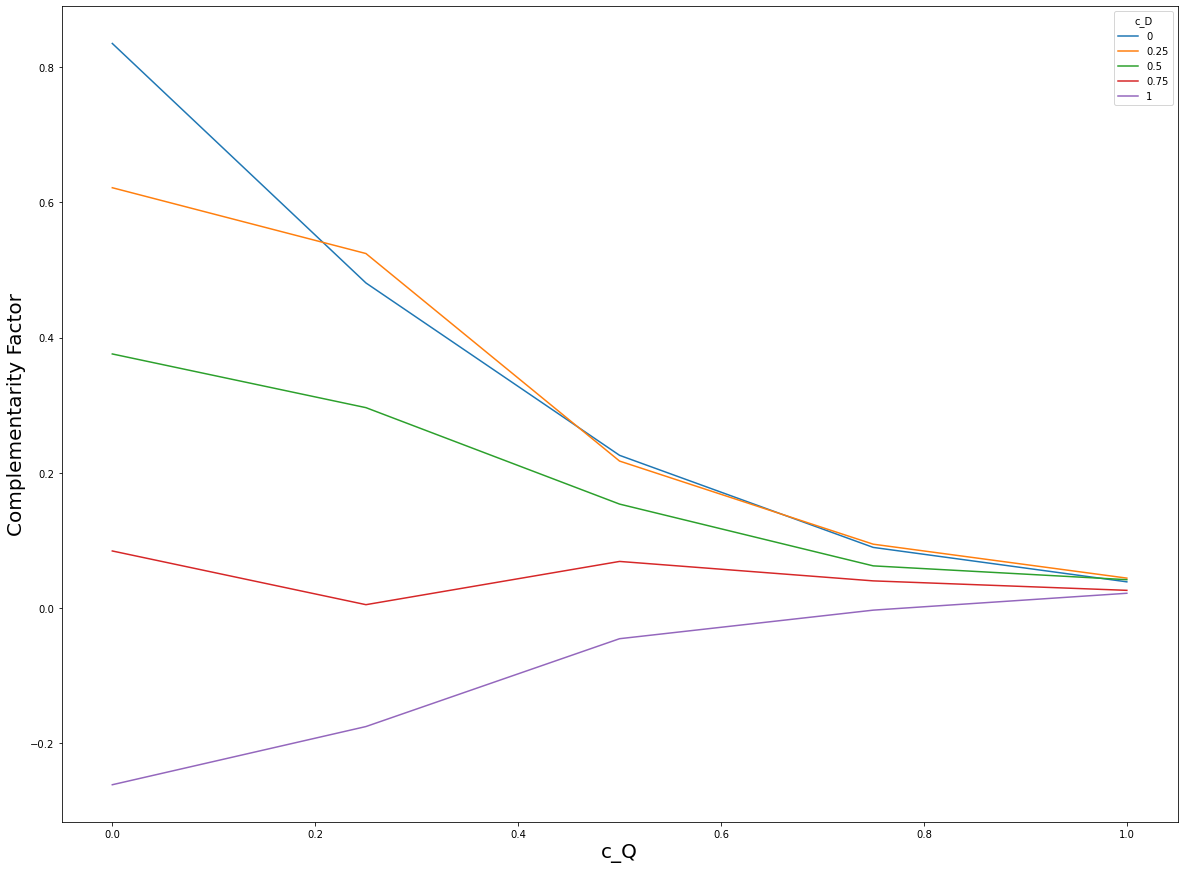

In [69]:
plt.figure(figsize=(20,15))

avg_dict = {}
for idx,inst in enumerate(instance_list):
    try:
        avg_dict[(inst.c_Q/inst.c, inst.c_D/inst.c)].append(inst.get_complementarity_factor())
    except:
        avg_dict[(inst.c_Q/inst.c, inst.c_D/inst.c)] = [inst.get_complementarity_factor()]

for c_Q in c_Q_list:
    temp1, temp2 = [], []
    for tup, val_list in avg_dict.items():
        if tup[1] == c_Q:
            temp1.append(tup[0])
            temp2.append(sum(val_list)/len(val_list))
    plt.plot(temp1,temp2)
print(temp1, temp2)
plt.legend(c_D_list, title="c_D")
plt.xlabel("c_Q", fontsize=20)
plt.ylabel("Complementarity Factor", fontsize=20)

# M and c_D

[1, 2, 3] [-0.2286959892621961, -0.09051044820620803, 0.040623029144471454]


Text(0, 0.5, 'Complementarity Factor')

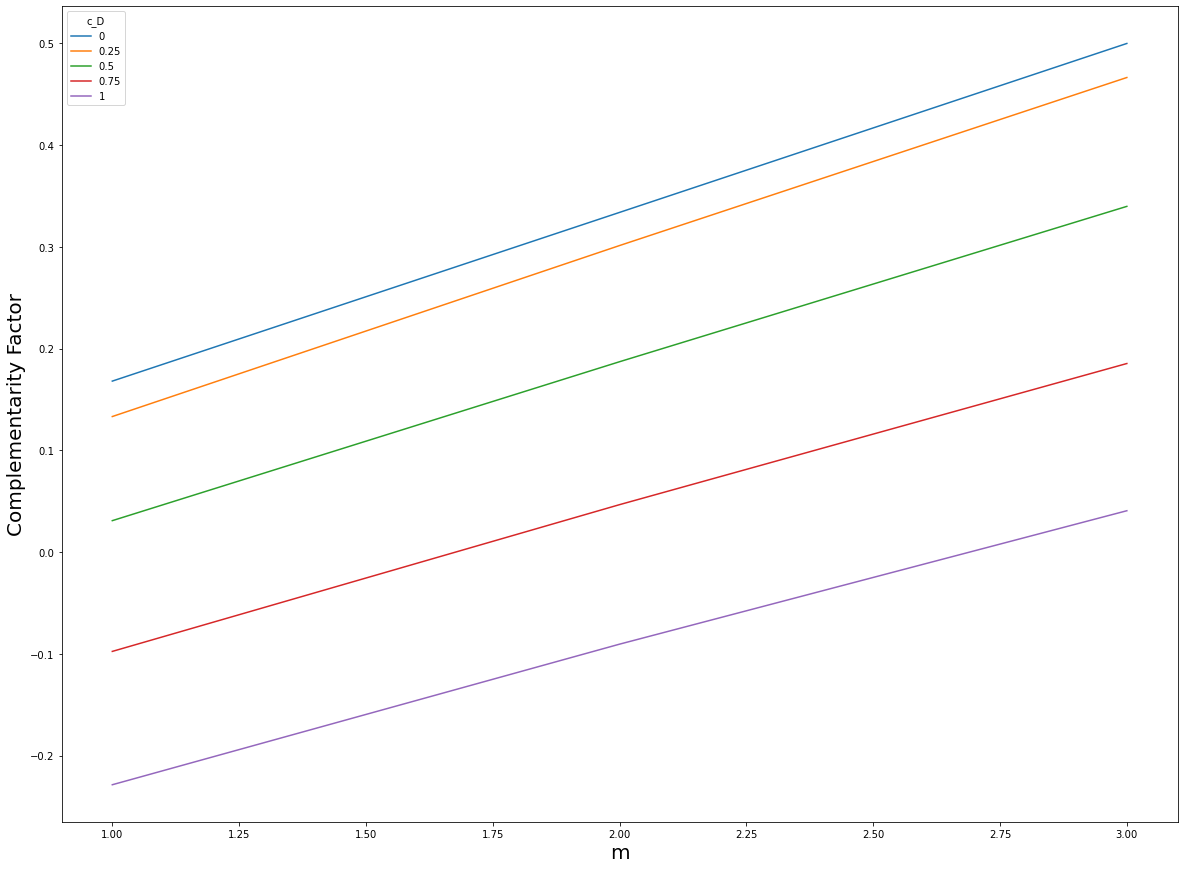

In [72]:
plt.figure(figsize=(20,15))

avg_dict = {}
for idx,inst in enumerate(instance_list):
    try:
        avg_dict[(inst.m, inst.c_D/inst.c)].append(inst.get_complementarity_factor())
    except:
        avg_dict[(inst.m, inst.c_D/inst.c)] = [inst.get_complementarity_factor()]

for c_D in c_D_list:
    temp1, temp2 = [], []
    for tup, val_list in avg_dict.items():
        if tup[1] == c_D:
            temp1.append(tup[0])
            temp2.append(sum(val_list)/len(val_list))
    plt.plot(temp1,temp2)
print(temp1, temp2)
plt.legend(c_D_list, title="c_D")
plt.xlabel("m", fontsize=20)
plt.ylabel("Complementarity Factor", fontsize=20)

In [ ]:
c_Q and delta

[0.0, 0.25, 0.5, 0.75, 1.0] [0.5940119329154993, 0.3985068461267073, 0.13396752192745778, 0.013114851430640334, 0.0001983147281666935]


Text(0, 0.5, 'Complementarity Factor')

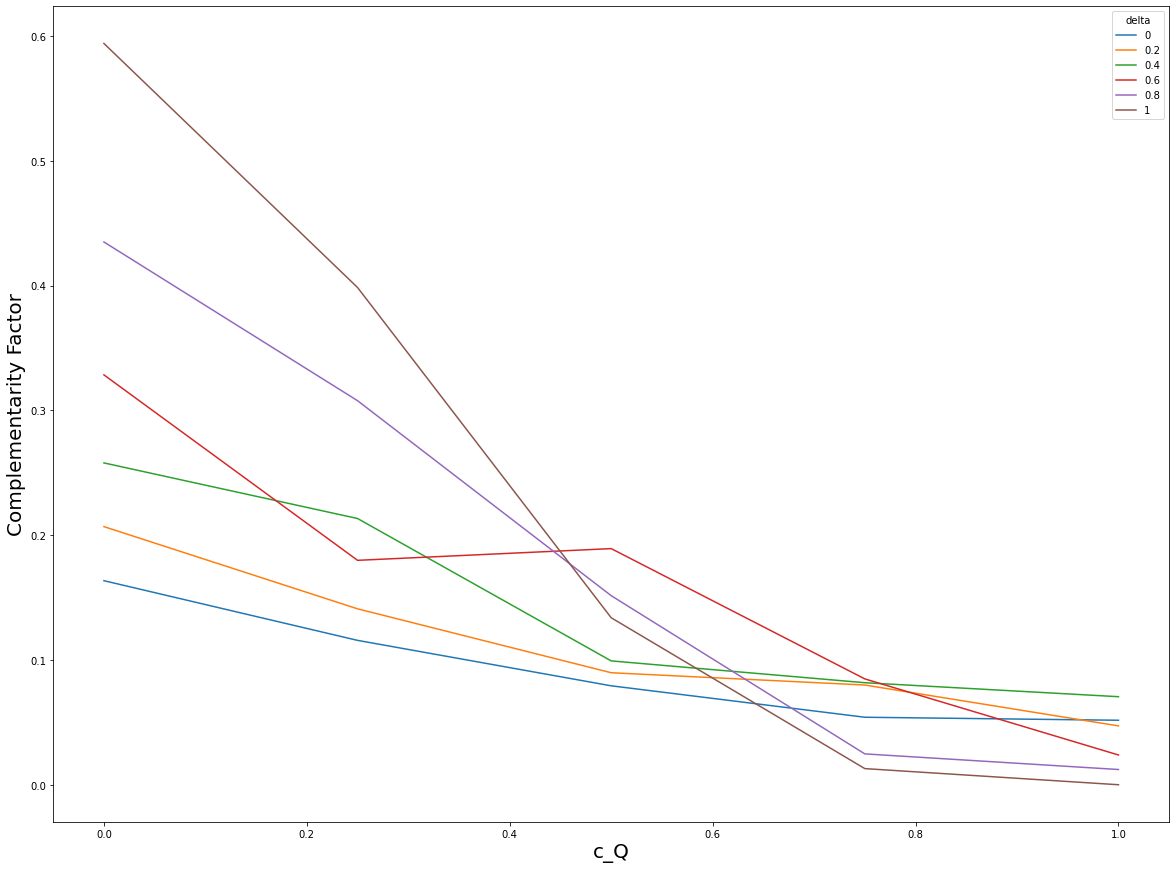

In [76]:
plt.figure(figsize=(20,15))

avg_dict = {}
for idx,inst in enumerate(instance_list):
    try:
        avg_dict[(inst.c_Q/inst.c, inst.delta)].append(inst.get_complementarity_factor())
    except:
        avg_dict[(inst.c_Q/inst.c, inst.delta)] = [inst.get_complementarity_factor()]

for delta in delta_list:
    temp1, temp2 = [], []
    for tup, val_list in avg_dict.items():
        if tup[1] == delta:
            temp1.append(tup[0])
            temp2.append(sum(val_list)/len(val_list))
    plt.plot(temp1,temp2)
print(temp1, temp2)
plt.legend(delta_list, title="delta")
plt.xlabel("c_Q", fontsize=20)
plt.ylabel("Complementarity Factor", fontsize=20)

# S

In [55]:
s1, s2, s3 = [], [], []
for inst in instance_list:
    if inst.s/inst.c == 0.5:
        s1.append(inst.get_complementarity_factor())
    if inst.s/inst.c == 0.6:
        s2.append(inst.get_complementarity_factor())
    if inst.s/inst.c == 0.7:
        s3.append(inst.get_complementarity_factor())

print(sum(s1) / len(s1))
print(sum(s2) / len(s2))
print(sum(s3) / len(s3))

0.15747196371772973
0.1519763296303663
0.16415972158984188


# Delta

In [56]:
delta1, delta2, delta3, delta4, delta5, delta6 = [], [], [], [], [], []
for inst in instance_list:
    if inst.delta == 0:
        delta1.append(inst.get_complementarity_factor())
    if inst.delta == 0.2:
        delta2.append(inst.get_complementarity_factor())
    if inst.delta == 0.4:
        delta3.append(inst.get_complementarity_factor())
    if inst.delta == 0.6:
        delta4.append(inst.get_complementarity_factor())
    if inst.delta == 0.8:
        delta5.append(inst.get_complementarity_factor())
    if inst.delta == 1:
        delta6.append(inst.get_complementarity_factor())
        
print(sum(delta1) / len(delta1))
print(sum(delta2) / len(delta2))
print(sum(delta3) / len(delta3))
print(sum(delta4) / len(delta4))
print(sum(delta5) / len(delta5))
print(sum(delta6) / len(delta6))


0.09301404830370953
0.11308137961143179
0.14470165113935446
0.161370982566129
0.18635722374179875
0.22795989342569423


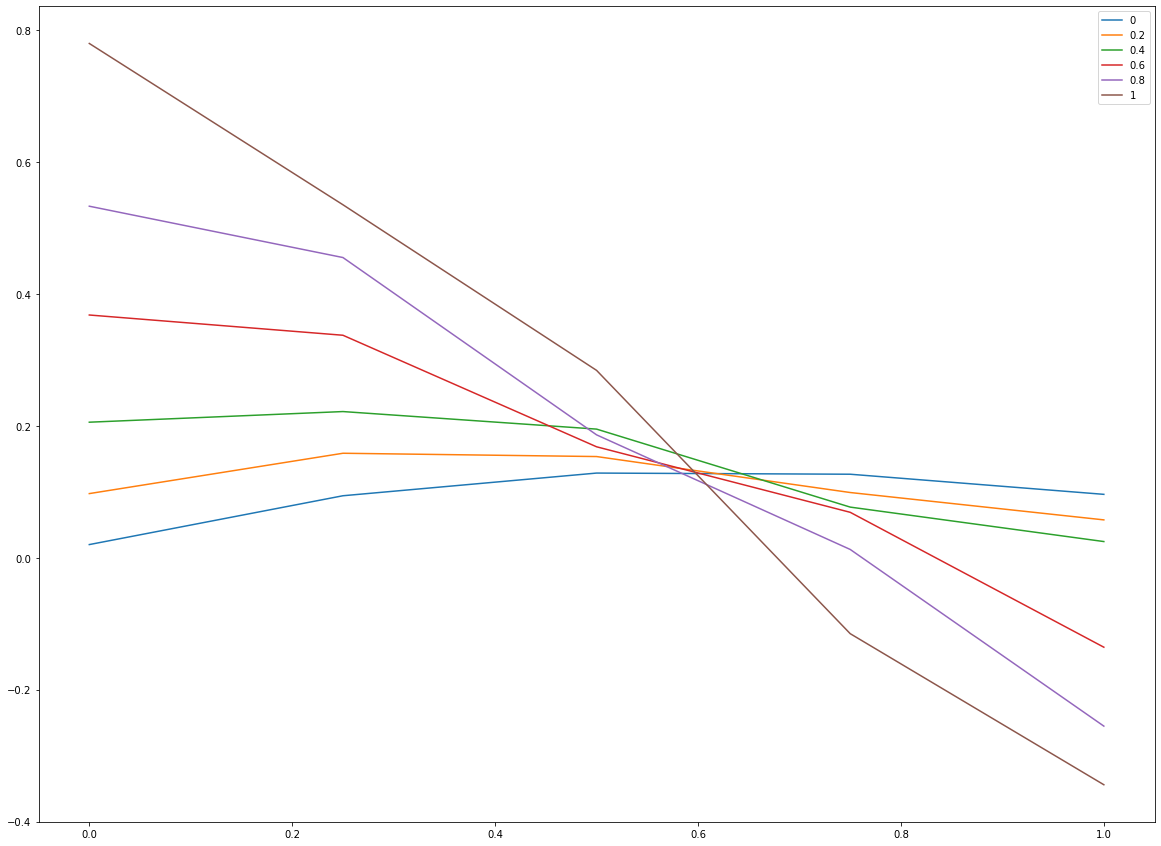

In [20]:
plt.figure(figsize=(20,15))

avg_dict = {}
for idx,val in enumerate(complementarity_inst):
    try:
        avg_dict[(c_D_by_c_inst[idx], delta_inst[idx])].append(val)
    except:
        avg_dict[(c_D_by_c_inst[idx], delta_inst[idx])] = [val]

for delta in delta_list:
    temp1, temp2 = [], []
    for tup, val_list in avg_dict.items():
        if tup[1] == delta:
            temp1.append(tup[0])
            temp2.append(sum(val_list)/len(val_list))
    plt.plot(temp1,temp2)
plt.legend(delta_list)

In [12]:
count = 0
for val in complementarity_list:
    if val < 0:
        count += 1
print(count)

3587


In [36]:
temp2

[0.7798097508849992,
 0.5352444342759058,
 0.28410063330671476,
 -0.11514501820225248,
 -0.34421033313689553]

In [49]:
inst = Instance((150,75,8,1,2,0.5,0,1.9/2,0.8))
print(inst.p_T, inst.p_D, inst.p_Q, inst.p_F)
print(inst.phi_T, inst.phi_D, inst.phi_Q, inst.phi_F)
'''
args = args[0]
        self.mu = args[0]
        self.sigma = args[1]
        self.v = args[2]
        self.m = args[3]
        self.c = args[4]
        self.c_D = args[5]*self.c
#         self.c_D = args[5]
        self.c_Q = args[6]*self.c
#         self.c_Q = args[6]
        self.s = args[7]*self.c
#         self.s = args[7]
        self.delta = args[8]
'''

sigma : 75, m:1, c:2, c_D:1.0, c_Q:0, s:1.9, delta:0.8
3.4374157643689256 5.208480325113124 8.0 9.0
199.9651226276978 241.2417236628898 900.0587273527268 900.7421521907619


'\nargs = args[0]\n        self.mu = args[0]\n        self.sigma = args[1]\n        self.v = args[2]\n        self.m = args[3]\n        self.c = args[4]\n        self.c_D = args[5]*self.c\n#         self.c_D = args[5]\n        self.c_Q = args[6]*self.c\n#         self.c_Q = args[6]\n        self.s = args[7]*self.c\n#         self.s = args[7]\n        self.delta = args[8]\n'

In [99]:
inst = Instance((150,75,8,1,2,0,0,1.9/2,0.8))
print(inst.p_T, inst.p_D, inst.p_Q, inst.p_F)
print(inst.phi_T, inst.phi_D, inst.phi_Q, inst.phi_F)

3.4374157643689256 3.64542261903051 8.0 9.0
202.52629433129678 232.77601061965777 900.0 1050.0
